In [1]:
from ipyleaflet import *

import junodch_utils_read_img as utils

import matplotlib.pyplot as matPlt
import numpy as np

import rasterio
from rasterio import plot as rastPlt

from localtileserver import get_leaflet_tile_layer, TileClient
from ipyleaflet import Map
from geemap import *

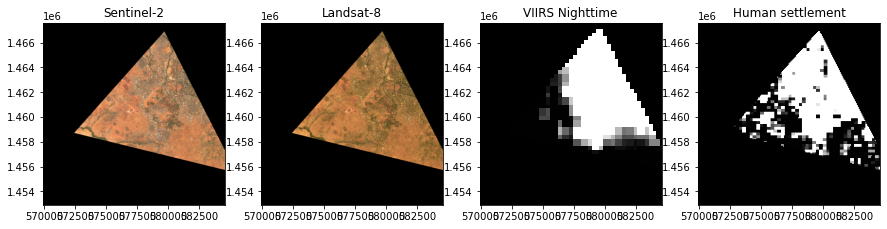

In [2]:
folderName = "img/Test/"
fig, axs = matPlt.subplots(1,4,figsize=(15,15))

axs[0].set_title("Sentinel-2")
with rasterio.open(folderName + "Sentinel-2_1.tif") as r:
    rastPlt.show(r, ax=axs[0])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())
axs[2].set_xlim(axs[0].get_xlim())
axs[2].set_ylim(axs[0].get_ylim())
axs[3].set_xlim(axs[0].get_xlim())
axs[3].set_ylim(axs[0].get_ylim())

axs[1].set_title("Landsat-8")
with rasterio.open(folderName + "Landsat-8_1.tif") as r: 
    rastPlt.show(r, ax=axs[1])

axs[2].set_title("VIIRS Nighttime")
with rasterio.open(folderName + "Night VIIRS_1.tif") as r:
    rastPlt.show(r, ax=axs[2])

axs[3].set_title("Human settlement")
with rasterio.open(folderName + "Population GHSL_1.tif") as r:
    rastPlt.show(r, ax=axs[3])


In [ ]:
folderName = "img/Test/"
fig, axs = matPlt.subplots(1,2,figsize=(10,10))

train, test = utils.getTrainingAndTestPerimeter(folderName + "Night VIIRS_1.tif", 200)

with rasterio.open(folderName + "Sentinel-2_1.tif") as l8:
  dataTrain, transformTrain = utils.getImgFromCoord(l8, train, False)
  dataTest, transformTest = utils.getImgFromCoord(l8, test, False)

  rastPlt.show(dataTrain, transform=transformTrain, ax=axs[0])
  rastPlt.show(dataTest, transform=transformTest, ax=axs[1])

# Combine images

In [ ]:
def combineImages(folder, nImg):
    listRaster = []
    for i in range(1, nImg + 1):
        listRaster.append(rasterio.open(folder + '_' + str(i) + '.tif'))
    output_meta = rasterio.open(folder + '_1.tif').meta.copy()

    mosaic, meta = utils.getMosaicFromFiles(listRaster, output_meta)
    
    return mosaic, meta

In [ ]:
mosaic, meta = combineImages('img/Sokoto/Sentinel-2', 64)
rastPlt.show(mosaic)

with rasterio.open('img/Sokoto/Sentinel-2.tif', 'w', **meta) as r:
  r.write(mosaic)

## Data visualization

In [ ]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
#pathNight = folderName + "Night VIIRS_1.tif"
pathNight = folderName + "lowres_night_1.tif"
pathValidation = folderName + "Population GHSL_1.tif"

aoi = utils.getImgBorder(pathSatellite)

dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, validThreshold=1, area=aoi)

#lightCoords = dataCoords[dataRadiance>200]

print('Tiles:',dataCoords.shape[0])
#print('Light Tile:',lightCoords.shape[0])

In [ ]:
def displayImgsInMask(dataCoords, pathSatellite, mask, batch=100):
  iSave = 0
  iNext = 0
  coords = dataCoords[mask]
  size = coords.shape[0]
  print('Size:',size)

  titles = ['']*size
  for i, v in enumerate(np.argwhere(mask)):
    titles[i] = 'N° ' + str(v)

  with rasterio.open(pathSatellite) as f:
    while iNext < size:
      iNext = iSave+batch
      if iNext > size:
        iNext = size
      dataImgs, _ = utils.getEachImgFromCoord(f, coords[iSave:iNext], True)
      dataImgs = utils.formatData(dataImgs, 64, False)
      
      utils.displayImgs(dataImgs, titles[iSave:iNext])
      iSave = iNext


In [ ]:
print('radiance >= 250:')
displayImgsInMask(dataCoords, pathSatellite, dataRadiance>=250)
print('radiance >= 200:')
displayImgsInMask(dataCoords, pathSatellite, (dataRadiance<250) & (dataRadiance>=200))
print('radiance >= 100:')
displayImgsInMask(dataCoords, pathSatellite, (dataRadiance<200) & (dataRadiance>=100))
print('radiance >= 75:')
displayImgsInMask(dataCoords, pathSatellite, (dataRadiance<100) & (dataRadiance>=75))
print('radiance >= 50:')
displayImgsInMask(dataCoords, pathSatellite, (dataRadiance<75) & (dataRadiance>=50))
print('radiance >= 25:')
displayImgsInMask(dataCoords, pathSatellite, (dataRadiance<50) & (dataRadiance>=25))
print('radiance > 1:')
displayImgsInMask(dataCoords, pathSatellite, (dataRadiance<25) & (dataRadiance>1))

# Overlap

In [3]:
from localtileserver import get_leaflet_tile_layer, TileClient
from geemap import *

from ipyleaflet import *

In [4]:
sentinelPath = 'img/Sokoto/Sentinel-2.tif'
resultPath = 'img/Sokoto/example2.tif'

# First, create a tile server from local raster file
#resultImg = TileClient(resultPath)
#sentinelImg = TileClient(sentinelPath)

m = geemap.Map(center=(0, 0), zoom=8)

resultImg = os.path.join(os.getcwd(), resultPath)
sentinelImg = os.path.join(os.getcwd(), sentinelPath)
m.add_local_tile(resultImg, bands=[3,2,1],layer_name='test')
#m.add_local_tile(sentinelImg, bands=[4,3,2],layer_name='sentinel')

#m.add_layer(get_leaflet_tile_layer(resultImg))
#m.add_layer(get_leaflet_tile_layer(sentinelImg))

display(m)

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Toggl…

In [ ]:
#path = 'img/Sokoto/Sentinel-2.tif'
path = 'img/Sokoto/example2.tif'

m = geemap.Map(center=(0, 0), zoom=1)
#m.add_control(ScaleControl(position='topright'))
#m.add_control(LayersControl())

#imgPath = os.path.join(os.getcwd(), path)
#m.add_local_tile(imgPath, bands=[4,3,2,1],layer_name='test')
m.add_layer(get_leaflet_tile_layer(TileClient(path)))

display(m)